This notebook presents how **Seismic Refraction Tomography** (SRT) works through `pyGIMLi`. 
It combines fundamental principles of seismic wave propagation with practical numerical example, taken from [here](https://www.pygimli.org/_examples_auto/2_seismics/plot_03_rays_layered_and_gradient_models.html#sphx-glr-examples-auto-2-seismics-plot-03-rays-layered-and-gradient-models-py)

**Author:** Alberto Carrera


## 1. Introduction

The seismic refraction method is a classical geophysical technique used to investigate the subsurface structure. It is based on the analysis of travel times of seismic waves (both P- and S-) generated by a source and recorded by a set of receivers (geophones).

A source (hammer blow, weight drop, or small explosive) generates a compressional (P) wave that travels through the subsurface.  
Receivers placed along a line record the first-arrival times of these waves at increasing distances from the source.

The velocity of seismic waves depends on the elastic properties of the medium: higher in dense and rigid materials, lower in loose or unconsolidated materials.


<img src="../figures/Refraction.png" style="width:30%; display:block; margin:auto;"/>


## 2. Theoretical Background

Seismic wave propagation is governed by the **wave equation**:

$$
\nabla^2 u(x,t) = \frac{1}{v^2} \frac{\partial^2 u(x,t)}{\partial t^2}
$$

where:
- $ u(x,t) $: displacement field,  
- $ v $: P-wave velocity, which depends on the elastic moduli and density of the medium.

At interfaces between layers of different velocities, seismic waves obey Snell’s law, which describes how the propagation angle changes with velocity:

$$
\frac{\sin \theta_1}{v_1} = \frac{\sin \theta_2}{v_2}
$$

- $v_1, v_2$: velocities in the upper and lower layers,  
- $ \theta_1, \theta_2 $: incidence and refraction angles.  

For typical subsurface profiles, $ v_2 > v_1 $, so waves bend away from the normal and can travel along the interface — this is known as critical refraction.



### 2.1 The wavetrain

The recorded first arrivals can include:
- Direct waves: traveling through the top layer directly to receivers.  
- Refracted (head) waves: traveling along deeper, faster layers and re-emerging at the surface.  
- Critical refraction: occurs when the incident angle satisfies .

- Direct waves – travel through the top layer directly from source to receiver.  
- Refracted (head) waves – travel down to a faster layer, along the interface, and back up to the surface.  
- Critically refracted waves – occur when the incident ray hits the layer boundary at the critical angle ($ \sin \theta_c = v_1 / v_2 $) and propagates horizontally along it.  
- Reflected waves – bounce back from subsurface interfaces before reaching the receivers.  
- Surface waves – travel along the ground surface with lower velocity and longer period.  
- Air waves – propagate through the air; usually weak and easily filtered out.  

In refraction analysis, we typically focus only on the **first arrivals**, which are usually **direct** or **critically refracted** waves.

<img src="../figures/waves.png" style="width:25%; display:block; margin:auto;"/>

### 2.2 Travel-Time Curve

The travel time $ t $ is recorded as a function of source–receiver distance $ x $.  
A typical travel-time curve shows a break where the refracted wave becomes the first arrival.

$$
t(x) = 
\begin{cases}
\frac{x}{v_1}, & \text{(direct wave)} \\
t_i + \frac{x}{v_2}, & \text{(refracted wave)}
\end{cases}
$$

The intercept time $t_i$ depends on the depth $h$ of the refractor:

$$
h = \frac{v_1 v_2 t_i}{2 \sqrt{v_2^2 - v_1^2}}
$$


### 2.3 Modeling Raypaths Numerically

While analytical equations work for simple geometries (like horizontal layers), real subsurface conditions are often complex.  
In those cases, we use numerical ray tracing, which finds the shortest travel-time path between a source and a receiver through a discretized velocity model.


## 3. Numerical Modeling with PyGIMLi

In [2]:
# Import necessary packages
from math import asin, tan
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer.mpl import drawMesh
from pygimli.physics import TravelTimeManager

### 3.1 Two-Layer model
We first create a simple two-layer model:
- upper layer: 1000 m/s
- lower layer: 3000 m/s
- interface depth: 25 m

Text(0.5, 1.0, 'Two-layer velocity model')

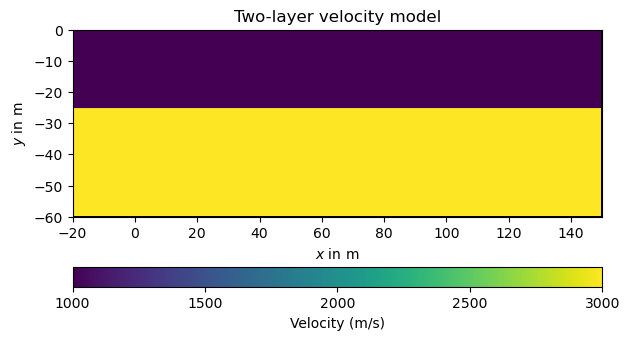

In [3]:
# Create a regular mesh grid
mesh_layered = mt.createGrid(
    np.arange(-20, 155, step=5, dtype=float),
    np.linspace(-60, 0, 13)
)

# Assign velocity values by depth
vel_layered = np.zeros(mesh_layered.cellCount())
for cell in mesh_layered.cells():
    vel_layered[cell.id()] = 3000.0 if cell.center().y() < -25 else 1000.0

# Visualize model
ax, cb = pg.show(mesh_layered, vel_layered, label="Velocity (m/s)")
ax.set_title("Two-layer velocity model")

### Analytical Travel-Time Solution (2-layer model)

We now compute the analytical travel-time curve for the two-layer case. The goal is to compare the travel times of the direct wave and the critically refracted wave.

1. **Direct wave travel time**:  
   - The wave that travels along the top layer straight to each receiver has a travel time proportional to the horizontal distance $x$ and inversely proportional to the velocity of the top layer $v_1$.  
   $$
   t_\text{direct} = \frac{x}{v_1}
  $$

2. **Critical refraction angle**:  
   - At the interface between two layers, the wave bends according to Snell’s law.  
   - The critical angle $\alpha$ is when the refracted wave travels along the boundary of the faster layer:
   $$
   \alpha = \arcsin\left(\frac{v_1}{v_2}\right)
   $$

3. **Horizontal distance traveled along the interface**:  
   - Once the wave reaches the interface, it travels horizontally before emerging back to the surface.  
   - The first “bounce point” along the interface is:
   $$
   x_\text{interface} = 2 \cdot h \cdot \tan(\alpha)
   $$

4. **Travel time of the refracted wave**:  
   - The total travel time is the sum of:
     - the time to reach the interface along the incident path,
     - the time along the horizontal path in the faster layer,
     - the time to exit to the surface.  
   - Using geometry and velocities:
   $$
   t_\text{refracted} = \frac{x - x_\text{interface}}{v_2} + x_\text{interface} \frac{v_2}{v_1^2}
   $$

5. **Select the first arrival**:  
   - At each receiver, the **first-arrival time** is the smaller of the direct and refracted travel times:
   $$
   t(x) = \min(t_\text{direct}, t_\text{refracted})
   $$

In [4]:
def analyticalSolution2Layer(x, zlay=25, v1=1000, v2=3000):
    """Analytical solution for 2-layer refraction."""
    tdirect = np.abs(x) / v1
    alfa = asin(v1 / v2)
    xreflec = tan(alfa) * zlay * 2.
    trefrac = (x - xreflec) / v2 + xreflec * v2 / v1**2
    return np.minimum(tdirect, trefrac)

### 3.2 Vertical Gradient Model

We now define a velocity gradient model where $ v(z) = a + b|z| $.  
This represents an increase in wave velocity with depth — a common feature in real sediments.


Text(0.5, 1.0, 'Vertical velocity gradient model')

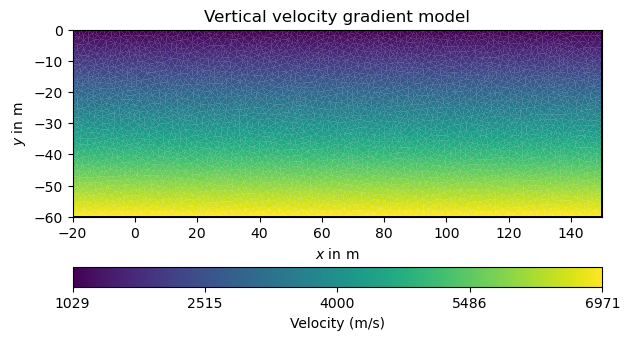

In [5]:
sensors = np.arange(131, step=10.0)
plc = mt.createWorld([-20, -60], [150, 0], worldMarker=False)

# Add sensor nodes on surface
for pos in sensors:
    plc.createNode([pos, 0.0])

# Create an unstructured mesh
mesh_gradient = mt.createMesh(plc, quality=33, area=3)

# Assign vertical gradient velocity field
a, b = 1000, 100
vel_gradient = [a + b * abs(node.y()) for node in mesh_gradient.nodes()]
vel_gradient = pg.meshtools.nodeDataToCellData(mesh_gradient, np.array(vel_gradient))

ax, cb = pg.show(mesh_gradient, vel_gradient, label="Velocity (m/s)")
ax.set_title("Vertical velocity gradient model")

### Analytical Travel-Time Solution (gradient model)

In a gradient model, the velocity increases gradually with depth:
$$
v(z) = a + b |z|
$$

1. **Direct wave travel time**:  
   - The wave traveling along the surface in the shallowest layer still takes:
   $$
   t_\text{direct} = \frac{x}{a}
  $$

2. **Refracted wave in a gradient**:  
   - Unlike the sharp two-layer case, the wave velocity continuously increases with depth, so the refracted path curves smoothly.  
   - Using a simplified analytical approximation (from travel-time integration), the travel time is:
   $$
   t_\text{refracted} = \frac{1}{b} \, \text{arccosh}\Bigg(1 + \frac{b^2 x^2}{2 a^2}\Bigg)
   $$

3. **First arrival selection**:  
   - As before, the first arrival is the smaller of the direct and refracted times.

In [6]:
def analyticalSolutionGradient(x, a=1000, b=100):
    """Analytical solution for gradient velocity model."""
    tdirect = np.abs(x) / a
    tmp = 1 + ((b**2 * np.abs(x)**2) / (2 * a**2))
    trefrac = np.abs(b**-1 * np.arccosh(tmp))
    return np.minimum(tdirect, trefrac)


### 3.3 Raytracing Simulation and Comparison

We now compute and compare the analytical travel times from both 2-layer and vertical gradient models.  `pyGIMLi` uses ray tracing with [Dijkstra’s](https://www.youtube.com/watch?v=CmIQ29cUGiE) shortest-path algorithm (Dijkstra, 1959) for numerical travel times computation on a disctretized mesh.  
The mesh nodes represent positions in space, and each cell has a defined velocity. Secondary nodes along cell edges can be added to improve angular resolution: more secondary nodes → more accurate approximation of curved or angled raypaths.  
Travel time is computed by summing the time along each segment:
  $$
  t_\text{segment} = \frac{\text{length}}{\text{velocity at segment}}
  $$
The first arrival is automatically selected at each receiver, just like in the analytical solutions.

07/10/25 - 11:14:58 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
07/10/25 - 11:14:58 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
07/10/25 - 11:14:59 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
07/10/25 - 11:15:00 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


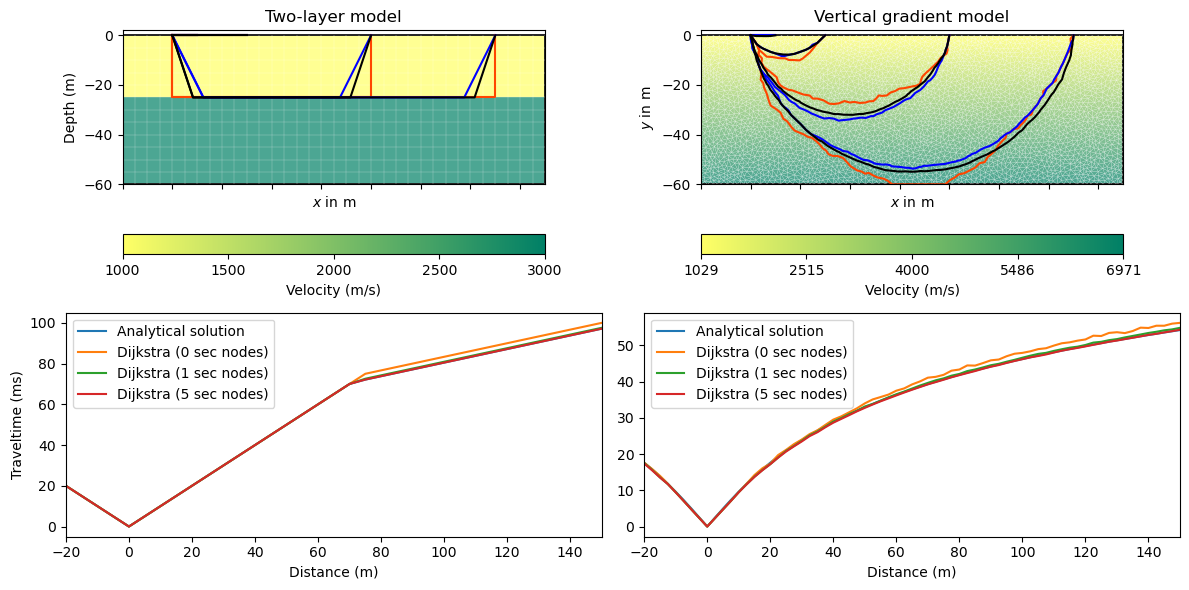

In [7]:
# velocity + raypaths and traveltime
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

for j, (case, mesh, vel) in enumerate(zip(
    ["layered", "gradient"],
    [mesh_layered, mesh_gradient],
    [vel_layered, vel_gradient])
):
    # analytical model
    ana = analyticalSolutionGradient if case == "gradient" else analyticalSolution2Layer

    # Prepare sensors and data container
    mx, my = pg.x(mesh), pg.y(mesh)
    px = np.sort(mx[my == 0.0])
    data = pg.DataContainer()
    data.registerSensorIndex('s')
    data.registerSensorIndex('g')
    for i, pxi in enumerate(px):
        data.createSensor([pxi, 0.0])
        if pxi == 0.0:
            source = i
    data.resize(len(px))
    data['s'] = [source] * len(px)
    data['g'] = range(len(px))

    # Draw velocity model with raypaths
    pg.show(mesh, vel, ax=ax[0, j], label="Velocity (m/s)", hold=True,
            logScale=False, cMap="summer_r", coverage=0.7)
    drawMesh(ax[0, j], mesh, color="white", lw=0.2)

    sec_nodes = [0, 1, 5]
    t_all = []
    mgr = TravelTimeManager()
    colors = ["orangered", "blue", "black"]
    recs = [1, 3, 8, 13]

    for i, n in enumerate(sec_nodes):
        res = mgr.simulate(vel=vel, scheme=data, mesh=mesh, secNodes=n)
        t_all.append(res['t'].array())

        # Plot raypaths for selected receivers
        for r, p in enumerate(recs):
            lab = f"{n} sec nodes" if r == 0 else None
            recNode = mgr.fop.mesh().findNearestNode([sensors[p], 0.0])
            sourceNode = mgr.fop.mesh().findNearestNode([0.0, 0.0])
            path = mgr.fop.dijkstra.shortestPath(sourceNode, recNode)
            points = mgr.fop.mesh().positions(withSecNodes=True)[path].array()
            ax[0, j].plot(points[:, 0], points[:, 1], colors[i], label=lab)

    # Plot travel times (analytical vs numerical)
    t_ana = ana(px)
    ax[1, j].plot(px, t_ana * 1000, label="Analytical solution")
    for i, n in enumerate(sec_nodes):
        ax[1, j].plot(px, t_all[i] * 1000, label=f"Dijkstra ({n} sec nodes)")

    ax[1, j].legend()
    ax[0, j].set_ylim(mesh.ymin(), 2)

ax[0, 0].set_title("Two-layer model")
ax[0, 1].set_title("Vertical gradient model")
ax[0, 0].set_ylabel("Depth (m)")
ax[1, 0].set_ylabel("Traveltime (ms)")
ax[1, 0].set_xlabel("Distance (m)")
ax[1, 1].set_xlabel("Distance (m)")
fig.tight_layout()


The top row shows the velocity distribution of each model, overlaid by raypaths computed with PyGIMLi for the selected receivers.  
Different colors correspond to simulations with different numbers of secondary nodes, showing how the numerical path approximation improves with more nodes.

The bottom row compares analytical first arrivals with numerical Dijkstra travel times.  
This validates that the numerical method can accurately approximate both sharp and smoothly varying velocity structures.

###  Differences between the two-layer and gradient models

- **Two-layer model:**  
The subsurface is simplified into two distinct layers with a sharp velocity contrast. The velocity jumps from $v_1$ (top layer) to $v_2\$ (bottom layer) at a fixed depth.  
The travel-time curve shows a clear break point: for short distances, the direct wave travels along the top layer. Beyond the critical distance, the refracted wave along the lower, faster layer becomes the first arrival.  
The analytical solution uses Snell’s law to compute the critical refraction angle and the horizontal travel along the interface.

- **Gradient model:**
The subsurface velocity increases gradually with depth, $v(z) = a + b|z|$, without sharp boundaries. There is no abrupt interface, so the travel-time curve is smoothly curved.  
Waves bend continuously as they penetrate deeper layers. The analytical solution approximates the travel-time using an integrated path along the velocity gradient, producing a smooth first-arrival curve.
